In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd

In [21]:
root_dir = 'C:/Users/fabri/OneDrive/Desktop/UPTP/Data Mining INDU/Data Visualization/C-NMC_Leukemia/training_data/fold_0'  
batch_size = 32
num_epochs = 15
lr = 0.001
img_size = 224

In [22]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [23]:
class ALLValidationDataset(Dataset):
    def __init__(self, image_dir, label_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(label_csv)
        self.transform = transform
        self.class_map = {'all': 0, 'hem': 1}

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.class_map[row['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

val_dir = 'C:/Users/fabri/OneDrive/Desktop/UPTP/Data Mining INDU/Data Visualization/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data'
val_csv = "C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"   

val_dataset = ALLValidationDataset(val_dir, val_csv, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
class ALLTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.bmp')])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

test_dir = "C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data"
test_dataset = ALLTestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
train_dataset = datasets.ImageFolder(root=root_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [28]:
class LeukemiaCNN(nn.Module):
    def __init__(self):
        super(LeukemiaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # 2 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
model = LeukemiaCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LeukemiaCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [30]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_loss:.4f}")
  

Epoch 1/15, Avg Train Loss: 0.5245


Epoch 2/15, Avg Train Loss: 0.4471


Epoch 3/15, Avg Train Loss: 0.4360


Epoch 4/15, Avg Train Loss: 0.4183


Epoch 5/15, Avg Train Loss: 0.4274


Epoch 6/15, Avg Train Loss: 0.4094


Epoch 7/15, Avg Train Loss: 0.3918


Epoch 8/15, Avg Train Loss: 0.3744


Epoch 9/15, Avg Train Loss: 0.3605


Epoch 10/15, Avg Train Loss: 0.3450


Epoch 11/15, Avg Train Loss: 0.3425


Epoch 12/15, Avg Train Loss: 0.3105


Epoch 13/15, Avg Train Loss: 0.2884


Epoch 14/15, Avg Train Loss: 0.2850


Epoch 15/15, Avg Train Loss: 0.2985


In [ ]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
val_losses.append(val_loss / len(val_loader))

print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


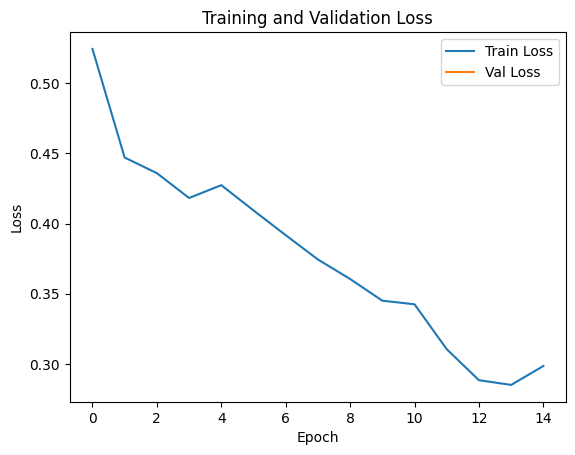

In [32]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [36]:
import csv

model.eval()
results = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Running Inference", leave=True)
    for inputs, filenames in progress_bar:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for fname, pred in zip(filenames, predicted.cpu().numpy()):
            label = 'all' if pred == 0 else 'hem'  # adjust if index mapping differs
            results.append((fname, label))

# Save predictions to CSV
with open('test_predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'prediction'])
    writer.writerows(results)

Running Inference: 100%|██████████| 81/81 [00:59<00:00,  1.35it/s]


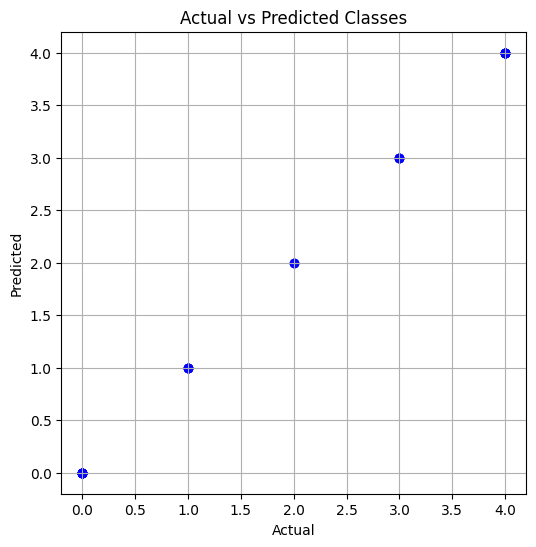

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()